In [3]:
# Example dataset (text descriptions mapped to chord sequences)
data = [
    ('an evil sinister uprising', 'Cm Gm Bb Fm'),
    ('a happy sunny day', 'C F G C'),
    ('a sorrowful and emotional moment', 'Am Dm F E7'),
]

# Split the dataset into input and output pairs
input_texts, output_chords = zip(*data)

# Tokenize the input and output sequences
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-small')

input_tokens = tokenizer(input_texts, return_tensors='pt', padding=True, truncation=True)
output_tokens = tokenizer(output_chords, return_tensors='pt', padding=True, truncation=True)

/Users/caslabs/opt/anaconda3/envs/music-gen/lib/python3.11/site-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [4]:
output_chords

('Cm Gm Bb Fm', 'C F G C', 'Am Dm F E7')

In [5]:
input_tokens

{'input_ids': tensor([[   46,  8293,  3731,  5805,    95,    52,  4890,     1],
        [    3,     9,  1095, 13546,   239,     1,     0,     0],
        [    3,     9, 27225,  1329,    11,  3973,   798,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1]])}

In [11]:
from transformers import T5ForConditionalGeneration, T5Config, AdamW
import torch

config = T5Config.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small', config=config)

# Generate the model graph
dot_file = 'model.dot'
dummy_input = torch.zeros([1, 512], dtype=torch.long)  # Create a dummy input tensor
torch.onnx.export(model, dummy_input, dot_file, opset_version=11, verbose=True)
print(f'Model graph saved to {dot_file}')

# Convert the dot file to an image (requires Graphviz)
image_file = 'model.png'
!dot -Tpng {dot_file} -o {image_file}
print(f'Model image saved to {image_file}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
input_tokens.to(device)
output_tokens.to(device)

# Training settings
epochs = 30
batch_size = 1
optimizer = AdamW(model.parameters(), lr=5e-4)

# Training loop
# Modified training loop
loss_values = []

for epoch in range(epochs):
    epoch_loss = 0.0

    for i in range(0, len(input_texts), batch_size):
        input_batch = input_tokens['input_ids'][i:i+batch_size].to(device)
        output_batch = output_tokens['input_ids'][i:i+batch_size].to(device)

        optimizer.zero_grad()
        
        outputs = model(input_ids=input_batch, labels=output_batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(input_texts)
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss}')
    loss_values.append(epoch_loss)

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



ValueError: You have to specify either decoder_input_ids or decoder_inputs_embeds

In [7]:
# Test input
test_input = 'a romantic evening'

# Tokenize the test input
test_input_tokens = tokenizer(test_input, return_tensors='pt').to(device)

# Generate output
model.eval()
with torch.no_grad():
    test_output_tokens = model.generate(test_input_tokens['input_ids'], num_return_sequences=1)

# Convert output tokens to chords
test_output_chords = tokenizer.decode(test_output_tokens[0], skip_special_tokens=True)
print(f'Test input: "{test_input}" -> Output chords: "{test_output_chords}"')



Test input: "a romantic evening" -> Output chords: "Am Dm F"


/Users/caslabs/opt/anaconda3/envs/music-gen/lib/python3.11/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


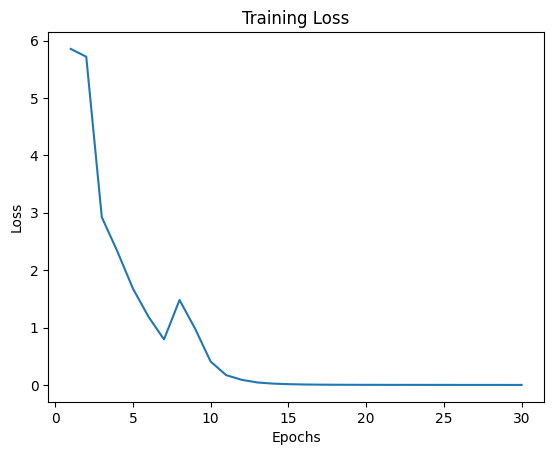

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(1, epochs + 1), loss_values)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [10]:
# Generate the model graph
dot_file = 'model.dot'
torch.onnx.export(model, input_tokens, dot_file, opset_version=11, verbose=True)
print(f'Model graph saved to {dot_file}')

# Convert the dot file to an image (requires Graphviz)
image_file = 'model.png'
!dot -Tpng {dot_file} -o {image_file}
print(f'Model image saved to {image_file}')

================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



RuntimeError: Only tuples, lists and Variables are supported as JIT inputs/outputs. Dictionaries and strings are also accepted, but their usage is not recommended. Here, received an input of unsupported type: BatchEncoding